In [1]:
!pip install torch

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/60/1b/9d3df1475d6c1548ad0278bc07fb396ef5f54418fb1f2acb4308feaa355e/torch-2.1.2-cp39-cp39-win_amd64.whl.metadata
  Using cached torch-2.1.2-cp39-cp39-win_amd64.whl.metadata (26 kB)
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/81/54/84d42a0bee35edba99dee7b59a8d4970eccdd44b99fe728ed912106fc781/filelock-3.13.1-py3-none-any.whl.metadata
  Using cached filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Obtaining dependency information for networkx from https://files.pythonhosted.org/packages/d5/f0/8fbc882ca80cf077f1b246c0e3c3465f7f415439bdea6b899f6b19f61f70/networkx-3.2.1-py3-none-any.whl.metadata
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Obtaining dependency information for fsspec from https://files.pythonhosted.org/packages/70/25/fab23259a52ece5670dcb8452e1af34b89e6135ecc17cd4


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!python.exe -m pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/15/aa/3f4c7bcee2057a76562a5b33ecbd199be08cdb4443a02e26bd2c3cf6fc39/pip-23.3.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ----------------- ---------------------- 0.9/2.1 MB 19.8 MB/s eta 0:00:01
   ---------------------------------------  2.1/2.1 MB 26.8 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 22.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1


# Build model

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from data_transformation import dataset_loader
import torch.functional as F

class PoseAdvisor(nn.Module):
    def __init__(self):
        super(PoseAdvisor, self).__init__()
        self.conv2d = nn.Conv2d(1, 32, (3, 3), padding=1)
        self.pool = nn.MaxPool2d((2, 2), stride=2)
        self.relu = nn.ReLU()
        self.conv2d_1 = nn.Conv2d(32, 64, (3, 3), padding=1)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(4194304,  1028)
        self.linear2 = nn.Linear(1028, 256)
        self.dropout = nn.Dropout(0.2)
        self.linear3 = nn.Linear(256, 39)

    def forward(self, x):
        print("INPUT", x.shape)
        x = self.conv2d(x)
        x = self.relu(x)
        x = self.pool(x)
        print("LAYER 1", x.shape)
        x = self.conv2d_1(x)
        x = self.relu(x)
        x = self.pool(x)
        print("LAYER 2", x.shape)
        x = self.flatten(x)
        x = self.linear(x)
        print("LAYER 3", x.shape)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_1(x)
        print("LAYER 4", x.shape)
        return x

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
model = PoseAdvisor().to(device)
optimizer = Adam(model.parameters(), lr=0.001)
loss = nn.MSELoss()
model

PoseAdvisor(
  (conv2d): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (conv2d_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=4194304, out_features=128, bias=True)
  (linear_1): Linear(in_features=128, out_features=39, bias=True)
)

In [3]:
device

device(type='cuda')

In [4]:
train_loader, test_loader = dataset_loader.dataload_create('images')

In [5]:
train_loader.dataset[0][1]

array([ 0.78235632,  0.30098727, -0.22005682,  0.69217646,  0.4050737 ,
       -0.04627819,  0.5868938 ,  0.28995377, -0.07000235,  0.64149421,
        0.59847176, -0.06349626,  0.        ,  0.        ,  0.        ,
        0.54123706,  0.71112847, -0.11458512,  0.        ,  0.        ,
        0.        ,  0.43829805,  0.58709222,  0.03271514,  0.34617269,
        0.52092505, -0.0325917 ,  0.59945709,  0.6359728 , -0.00992404,
        0.36579838,  0.39923304, -0.45197642,  0.        ,  0.        ,
        0.        ,  0.49879414,  0.70902103, -0.490132  ])

In [6]:
def train(epochs):
    model.train()
    for epoch in range(epochs):
        print(f'Epoch: {epoch}')
        best_loss = float('inf')
        total_loss = 0
        number_of_iterations = 0
        for i, (x, y) in enumerate(train_loader):
            if (x is None) or (y is None):
                continue
            print('Training: ', i)
            print(type(x), x.shape, type(y), y.shape)
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_hat = model(x)
            y_hat = y_hat.float()
            y = y.float()
            loss_val = loss(y_hat, y)
            total_loss += loss_val
            number_of_iterations += 1
            if loss_val < best_loss:
                best_loss = loss_val
            loss_val.backward()
            optimizer.step()
        average_loss = total_loss / number_of_iterations
        print(f'Epoch: {epoch}, Best loss: {best_loss.item()}, Average loss: {average_loss.item()}')
                
    with open('model.pth', 'wb') as f:
        torch.save(model.state_dict(), f)

In [7]:
train(10)

Epoch: 0
---------------------LANDMARK NOT DETECTED ERROR----------------------
---------------------LANDMARK NOT DETECTED ERROR----------------------
---------------------LANDMARK NOT DETECTED ERROR----------------------
---------------------LANDMARK NOT DETECTED ERROR----------------------
Training:  0
<class 'torch.Tensor'> torch.Size([32, 1, 256, 256]) <class 'torch.Tensor'> torch.Size([32, 39])
---------------------LANDMARK NOT DETECTED ERROR----------------------
Training:  1
<class 'torch.Tensor'> torch.Size([32, 1, 256, 256]) <class 'torch.Tensor'> torch.Size([32, 39])
---------------------LANDMARK NOT DETECTED ERROR----------------------
---------------------LANDMARK NOT DETECTED ERROR----------------------
Training:  2
<class 'torch.Tensor'> torch.Size([32, 1, 256, 256]) <class 'torch.Tensor'> torch.Size([32, 39])
---------------------LANDMARK NOT DETECTED ERROR----------------------
---------------------LANDMARK NOT DETECTED ERROR----------------------
---------------------L

In [9]:
torch.save(model.state_dict(), 'models/model1.pth')

In [7]:
model.load_state_dict(torch.load('models/model1.pth'))

<All keys matched successfully>

torch.Size([1, 1, 256, 256]) torch.float32 cpu tensor([[[[180., 180., 182.,  ..., 164., 164., 165.],
          [180., 179., 180.,  ..., 164., 165., 165.],
          [183., 182., 183.,  ..., 165., 164., 164.],
          ...,
          [ 80.,  77.,  82.,  ...,  17.,  17.,  18.],
          [ 85.,  83.,  85.,  ...,  19.,  23.,  24.],
          [ 92.,  84.,  84.,  ...,  28.,  28.,  26.]]]])
torch.Size([1, 39]) torch.float32 cuda:0 tensor([[ 0.0826, -0.0183, -0.0206,  0.0395, -0.0834, -0.0524, -0.0111,  0.0660,
         -0.0879,  0.0056, -0.0249,  0.0780, -0.0075,  0.0278,  0.0093, -0.0796,
         -0.0916,  0.0100,  0.0025,  0.0168,  0.0478,  0.0509, -0.0056, -0.0478,
          0.0757, -0.0362,  0.0896,  0.0747,  0.0559,  0.0774, -0.0799, -0.0010,
          0.0725, -0.0400,  0.0702,  0.0130, -0.0136,  0.0333, -0.0849]],
       device='cuda:0')


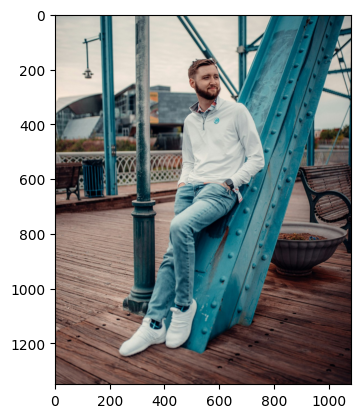

In [8]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

def preprocess(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    image = image.resize((256, 256))
    image = image.convert('L')
    image = np.array(image)
    image = image.reshape(1, 1, 256, 256)
    image = torch.from_numpy(image)
    image = image.float()
    print(image.shape, image.dtype, image.device, image)
    return image

img = preprocess('C:/Users/jalil/OneDrive/Desktop/New folder (4)/Posely/images/image_0d9d9936977540e59fb0709c900c5ff5.jpg')
def predict(x):
    model.eval()
    with torch.no_grad():
        x = x.to(device)
        y_hat = model(x)
        return y_hat
    
dots = predict(img)
print(dots.shape, dots.dtype, dots.device, dots)

In [9]:
dots = dots.reshape(13, 3)
dots = dots.cpu().numpy()
dots.shape, dots.dtype, dots

((13, 3),
 dtype('float32'),
 array([[ 0.08257981, -0.0182615 , -0.02059075],
        [ 0.03946723, -0.0833893 , -0.05243823],
        [-0.0111439 ,  0.06600164, -0.08794927],
        [ 0.00555544, -0.02493247,  0.07798278],
        [-0.00753174,  0.02783363,  0.00929508],
        [-0.07957801, -0.09158812,  0.00998307],
        [ 0.00249699,  0.01681006,  0.04780976],
        [ 0.05089832, -0.00560552, -0.04779603],
        [ 0.07566486, -0.03619646,  0.08964593],
        [ 0.07466293,  0.05586309,  0.07740343],
        [-0.07992897, -0.00098952,  0.07250269],
        [-0.03995478,  0.07018353,  0.01295899],
        [-0.01363169,  0.03327456, -0.08494963]], dtype=float32))

In [12]:
import data_transformation.landmark_utils as landmark_utils

print(landmark_utils.generate_landmarks('C:/Users/jalil/OneDrive/Desktop/New folder (4)/Posely/images/image_0d9d9936977540e59fb0709c900c5ff5.jpg'))
landmark_utils.draw_landmarks('C:/Users/jalil/OneDrive/Desktop/New folder (4)/Posely/images/image_0d9d9936977540e59fb0709c900c5ff5.jpg', dots)

[[ 0.52983224  0.18452272 -0.26606053]
 [ 0.62264752  0.26335192 -0.02170859]
 [ 0.45723692  0.28684399  0.14326724]
 [ 0.68063235  0.38167128 -0.06234985]
 [ 0.          0.          0.        ]
 [ 0.60895926  0.45444715 -0.20499547]
 [ 0.          0.          0.        ]
 [ 0.57650965  0.48896039 -0.11228001]
 [ 0.48346838  0.48775467  0.11244339]
 [ 0.43146527  0.57783532 -0.52392918]
 [ 0.38260695  0.61761963 -0.12096845]
 [ 0.4250989   0.78398621 -0.55808252]
 [ 0.33105335  0.82350135 -0.25771418]]


array([[ 0.08257981, -0.0182615 , -0.02059075],
       [ 0.03946723, -0.0833893 , -0.05243823],
       [-0.0111439 ,  0.06600164, -0.08794927],
       [ 0.00555544, -0.02493247,  0.07798278],
       [-0.00753174,  0.02783363,  0.00929508],
       [-0.07957801, -0.09158812,  0.00998307],
       [ 0.00249699,  0.01681006,  0.04780976],
       [ 0.05089832, -0.00560552, -0.04779603],
       [ 0.07566486, -0.03619646,  0.08964593],
       [ 0.07466293,  0.05586309,  0.07740343],
       [-0.07992897, -0.00098952,  0.07250269],
       [-0.03995478,  0.07018353,  0.01295899],
       [-0.01363169,  0.03327456, -0.08494963]], dtype=float32)